# NBA Players of the Week 

## Kevin Chen

## 1. Introduction

## 2. Data Collection and Processing

Here, I'm reading a csv file that I found on Kaggle that lists the NBA Players of the Week from 1985 to the current NBA season.
Link to file: https://www.kaggle.com/jacobbaruch/nba-player-of-the-week

In [287]:
import pandas as pd
import numpy as np
import seaborn as sns

nba = pd.read_csv("NBA_player_of_the_week.csv")
nba

,Active season,Player,Team,Conference,Date,Position,Height,Weight,Age,Draft Year,Seasons in league,Season,Season short,Real_value
0,0,Micheal Ray Richardson,New Jersey Nets,NaN,"Apr 14, 1985",PG,6-5,189,29,1978,6,1984-1985,1985,1.0
1,0,Derek Smith,Los Angeles Clippers,NaN,"Apr 7, 1985",SG,6-6,205,23,1982,2,1984-1985,1985,1.0
2,0,Calvin Natt,Denver Nuggets,NaN,"Apr 1, 1985",F,6-6,220,28,1979,5,1984-1985,1985,1.0
3,0,Kareem Abdul-Jabbar,Los Angeles Lakers,NaN,"Mar 24, 1985",C,7-2,225,37,1969,15,1984-1985,1985,1.0
4,0,Larry Bird,Boston Celtics,NaN,"Mar 17, 1985",SF,6-9,220,28,1978,5,1984-1985,1985,1.0
5,0,Darrell Griffith,Utah Jazz,NaN,"Mar 10, 1985",SG,6-4,190,26,1980,4,1984-1985,1985,1.0
6,0,Sleepy Floyd,Golden State Warriors,NaN,"Mar 3, 1985",PG,6-3,170,24,1982,2,1984-1985,1985,1.0
7,0,Mark Aguirre,Dallas Mavericks,NaN,"Feb 24, 1985",SF,6-6,232,25,1981,3,1984-1985,1985,1.0
8,0,Magic Johnson,Los Angeles Lakers,NaN,"Feb 17, 1985",PG,6-9,255,25,1979,5,1984-1985,1985,1.0
9,0,Dominique Wilkins,Atlanta Hawks,NaN,"Feb 3, 1985",SF,6-7,200,25,1982,2,1984-1985,1985,1.0


### 2A. Data Tidying

I'm getting rid of irrelevant information such as active season. 

There are some inconsistencies regarding position (GF is the same as G-F, etc.) so I'm also normalizing the positions.

There are also inconsistencies regarding teams that have been renamed (SuperSonics -> Thunder, Bullets -> Wizards), so I'm updating those values.

However, Charlotte and New Orleans follow special rules. In 2002, the Charlotte Hornets moved to New Orleans and Charlotte ceased to have an NBA team. But in 2004, the Charlotte Bobcats were created. In 2013, the New Orleans Hornets changed their name to the New Orleans Pelicans. In 2014, the Charlotte Bobcats were renamed back to the Charlotte Hornets. Kinda confusing, but I'll account for this by standardizing to their current names (Charlotte Hornets and New Orleans Pelicans). 

I'm also changing the date to datetime. 

In [288]:
# In terms of position, GF = G-F and FC = F-C, so we merge those values
nba.Position[nba.Position == 'G-F'] = 'GF'
nba.Position[nba.Position == 'F-C'] = 'FC'
# Changing date to datetime
nba.Date = pd.to_datetime(nba.Date)

nba.columns = ['Active season', 'Player', 'Team', 'Conference', 'Date', 'Position', 'Height', 'Weight', 'Age', 'draft_year', 
              'seasons_in_league', 'Season', 'season_short', 'Real_value']


# Changing names of teams that don't exist anymore
nba.Team[nba.Team == 'Seattle SuperSonics'] = 'Oklahoma City Thunder'
nba.Team[nba.Team == 'Washington Bullets'] = 'Washington Wizards'

nba.loc[(nba.Team == 'New Orleans Hornets') & (nba.season_short>=2003) & (nba.season_short<=2013), 'Team']='New Orleans Pelicans' 
nba.loc[nba.Team =='Charlotte Bobcats', 'Team'] = 'Charlotte Hornets'

# Dropping irrelevant columns
nba.drop('Active season', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launche

### 2B. More Data Tidying

I realized that the height and the weight aren't standardized correctly. Because the height in in Foot-Inches, it's hard to work with, so I have to convert the height into cm. And because I'm converting the height into cm (Metric units), I should convert the weight, which is currently in pounds (lb) into kilograms (kg).

In [289]:
# function for converting height to cm
def cmHeight(x):
    if 'cm' in x:
        return int(x.replace('cm',''))
    else:
        foot = int(x.split('-')[0])
        inches = int(x.split('-')[1])
        return ((foot*12 + inches)*2.54)
    
# function for converting lbs to kg
def kgWeight(x):
    return (int(x)*0.453592)
    
# applying to data
nba['Height_cm'] = nba.apply(lambda row : cmHeight(row['Height']),axis = 1)
nba['Weight_kg'] = nba.apply(lambda row : kgWeight(row['Weight']),axis = 1)
nba.drop('Height', axis=1, inplace=True)
nba.drop('Weight', axis=1, inplace=True)
nba

,Player,Team,Conference,Date,Position,Age,draft_year,seasons_in_league,Season,season_short,Real_value,Height_cm,Weight_kg
0,Micheal Ray Richardson,New Jersey Nets,NaN,1985-04-14,PG,29,1978,6,1984-1985,1985,1.0,195.58,85.728888
1,Derek Smith,Los Angeles Clippers,NaN,1985-04-07,SG,23,1982,2,1984-1985,1985,1.0,198.12,92.986360
2,Calvin Natt,Denver Nuggets,NaN,1985-04-01,F,28,1979,5,1984-1985,1985,1.0,198.12,99.790240
3,Kareem Abdul-Jabbar,Los Angeles Lakers,NaN,1985-03-24,C,37,1969,15,1984-1985,1985,1.0,218.44,102.058200
4,Larry Bird,Boston Celtics,NaN,1985-03-17,SF,28,1978,5,1984-1985,1985,1.0,205.74,99.790240
5,Darrell Griffith,Utah Jazz,NaN,1985-03-10,SG,26,1980,4,1984-1985,1985,1.0,193.04,86.182480
6,Sleepy Floyd,Golden State Warriors,NaN,1985-03-03,PG,24,1982,2,1984-1985,1985,1.0,190.50,77.110640
7,Mark Aguirre,Dallas Mavericks,NaN,1985-02-24,SF,25,1981,3,1984-1985,1985,1.0,198.12,105.233344
8,Magic Johnson,Los Angeles Lakers,NaN,1985-02-17,PG,25,1979,5,1984-1985,1985,1.0,205.74,115.665960
9,Dominique Wilkins,Atlanta Hawks,NaN,1985-02-03,SF,25,1982,2,1984-1985,1985,1.0,200.66,90.718400


## 3. Exploratory Analysis & Data Visualization


### 3A. Who are the most and least successful teams (in terms of number of Players of the Week)?


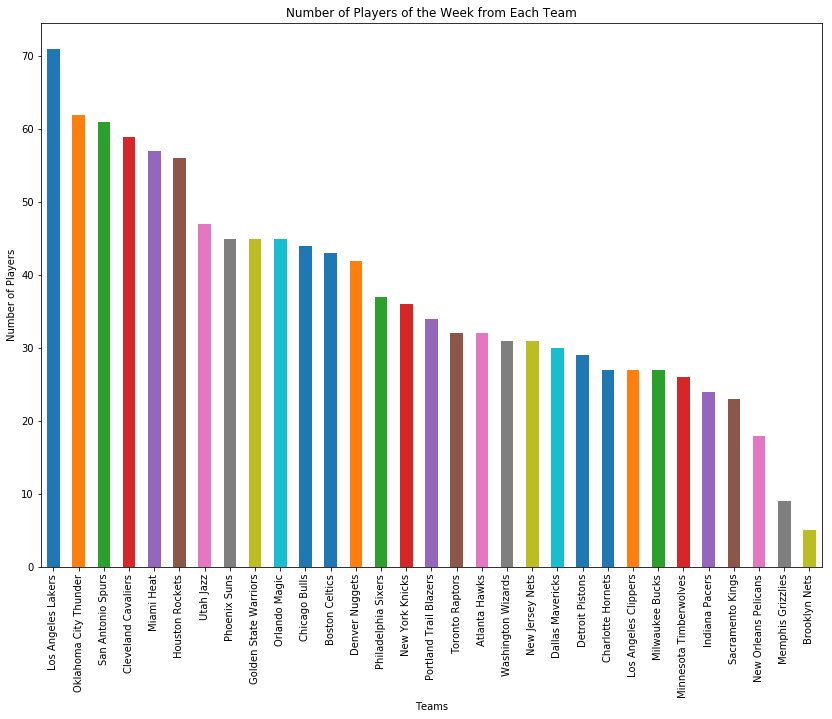

In [290]:
import matplotlib.pyplot as plt

# Plotting teams and their number of players who have recieved the award through a bar graph

ax = nba['Team'].value_counts().plot(kind='bar', figsize=(14,10), title="Number of Players of the Week from Each Team")
ax.set_xlabel("Teams")
ax.set_ylabel("Number of Players")
plt.show()


As you can see through the bar graph, the Los Angeles Lakers have the highest number of players of the week (with over 70), while the Brooklyn Nets have the lowest number of players of the week (under 10). 

### 3B. What is the average age of players from each draft year?

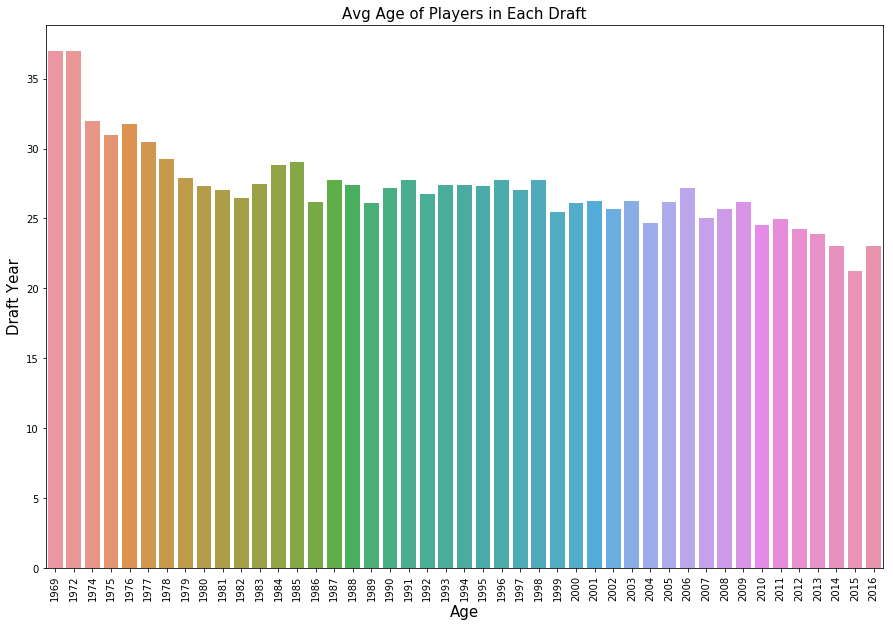

In [291]:
nba.Age= nba.Age.astype(float)
draft_years= list(nba['draft_year'].unique())
age_values= []

for i in draft_years:
    x= nba[nba['draft_year'] == i]
    avg = sum(x.Age)/len(x) # taking average
    age_values.append(avg)

data = pd.DataFrame({'draft_years': draft_years, 'age_values':age_values})
new_index = (data['age_values'].sort_values(ascending=False)).index.values 
sorted_data = data.reindex(new_index)

#P lotting
plt.figure(figsize=(15,10))
sns.barplot(x=sorted_data['draft_years'], y=sorted_data['age_values'])
plt.xticks(rotation= 90)
plt.xlabel('Age', size=15)
plt.ylabel('Draft Year', size=15)
plt.title('Avg Age of Players in Each Draft', size=15)
plt.show()

As you can see through the bar graph, the average age, which was almost 40 in 1969, has steadily decreased to what is 25 in 2016. This is likely because as the NBA has become more popular, more and more players from college have gotten drafted, decreasing the average age. Also, younger players have more potential and athleticism than older players. 

### 3C. What is the proportion of Players of the Week (in terms of the positions that they play)? 

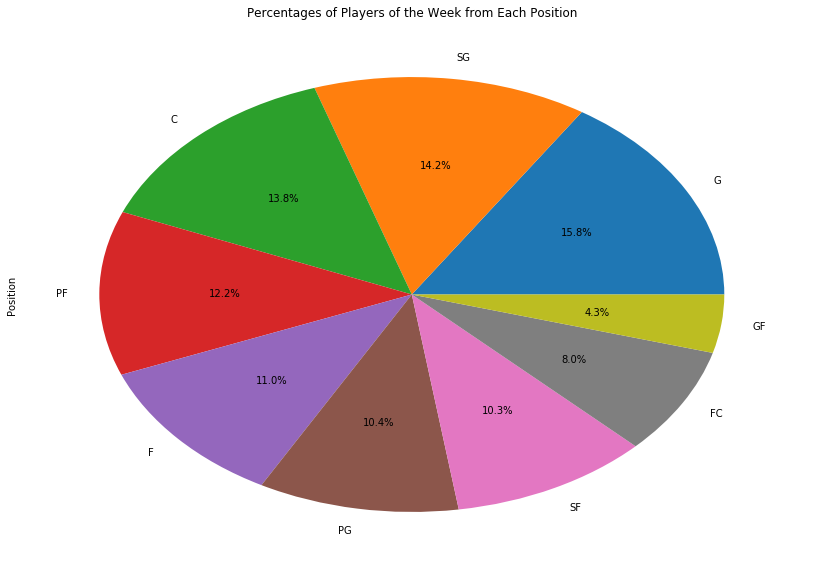

In [292]:
# Plotting position and number of players from that position that have recieved the award through a pie chart
ax2 = nba['Position'].value_counts().plot(kind='pie', figsize=(14,10), autopct='%1.1f%%', title="Percentages of Players of the Week from Each Position")
plt.show()

First, I'll explain the basketball positions so that it's easier to understand the chart. In basketball, there are 5 positions: Point Guard, Shooting Guard, Power Forward, Small Forward, and Center. 

Here are what the position variables mean: 
..*PG - Point Guard
..*SG - Shooting Guard
..*SF - Small Forward
..*PF - Power Forward
..*C - Center
..*G - Guard (Can play Point Guard and Shooting Guard
..*F - Forward (Can play either Small Forward and Power Forward)
..*GF - Guard-Forward (Can play Shooting Guard and Small Forward)
..*FC - Forward-Center (Can play Power Forward and Center)


From the pie chart, the majority of players who won the award of Player of the Week played the versatile Guard position and the Shooting Guard position. In contrast, there weren't many players of the week who played Guard-Forward, Forward-Center, or Small Forward.  

### 3D. Visualizing BMI vs Position

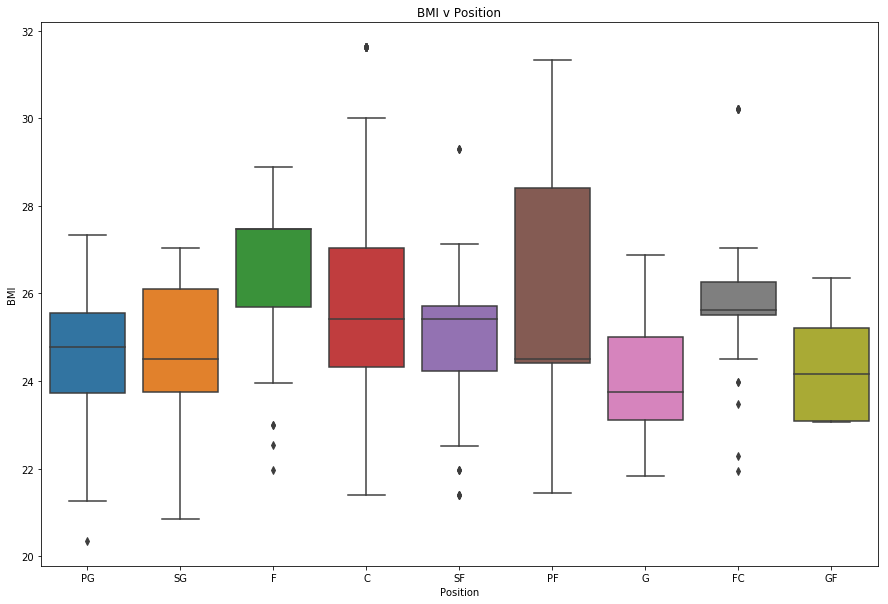

In [293]:
# Calculating BMI and adding it to dataframe
nba['BMI'] = nba['Weight_kg']/((nba['Height_cm']/100)**2)

plt.figure(figsize=(15,10))
plt.title('BMI v Position')
sns.boxplot(x='Position',y='BMI',data=nba)



Here, we can see that the upper echelon of BMI belong to Power Forwards and Centers. This makes sense because those positions typically require the largest amount of body mass. Power forwards typically play in the low post area in basketball, which means that they need to aggressive in boxing people out and getting rebounds. The Center position typically belongs to the biggest men on the court, as they need to play close to the basket to get rebounds and protect the rim. 

In contrast, Guards (PG, SG, G, GF) make up the lower echelon of BMI. This also makes sense because Guards typically need to be agile and fast. This is because they need to be able to drive to the basket quickly, get steals on defense, maneuver around defenders to get open, and dictate the offensive flow for the team. 

### 3E. Who are the players who have won the award of Player of the Week the most? 

Text(0.5,1,'Top 10 Players awarded Player of the Week the most')

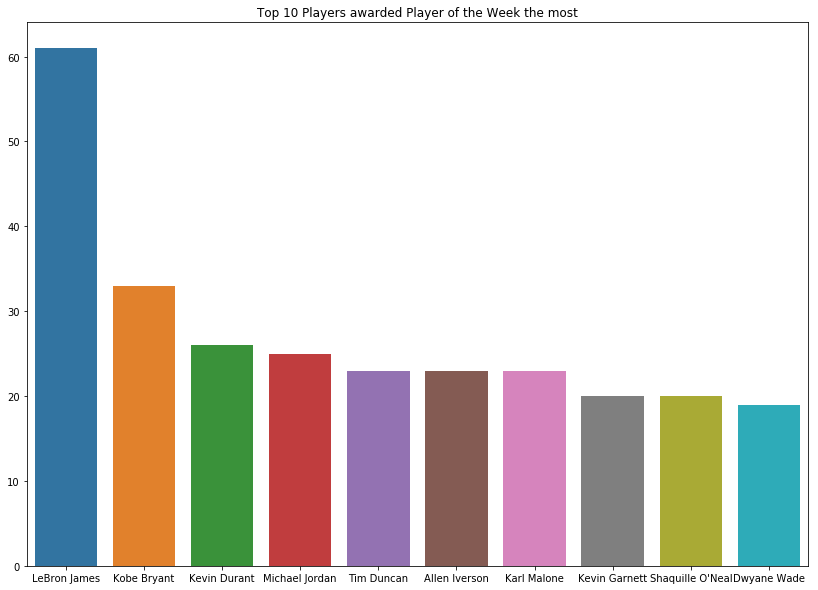

In [294]:
top_players = nba.Player.value_counts()
plt.figure(figsize=(14,10))
sns.barplot(x=top_players[:10].index, y=top_players[:10].values) # showing top 10
plt.title("Top 10 Players awarded Player of the Week the most")

Here, we can see that by an extraordinary amount, LeBron James has won Player of the Week more than 60 times. This is almost double of Kobe Bryant, who is in second place. The next 8 players all, comparatively, have smaller margins between winnings.  

### 3F. Let's visualize the impact of each of the top 5 players awarded Player of the Week

Here, we are standardizing according to real value. Because the Eastern and Western conferences weren't established until the 2001 NBA season, the Player of the Week for seasons before 2001 only include one player from all NBA teams instead of one player from each conference. Thus, the real value for those players is 1 and the real value for players after the Eastern and Western conferences were established is .5 because they had to share the award with another player on the other conference.

For example, LeBron James could've won the Player of the Week award for the Eastern Conference and Kevin Durant could've won the Player of the Week in the same week for the Western Conference. However, Derek Smith (who played in 1985) would've been the sole recipient of the Player of the Week award because there were no conferences. Thus, LeBron and Durant's real values would've been .5 each while Smith's was 1. 

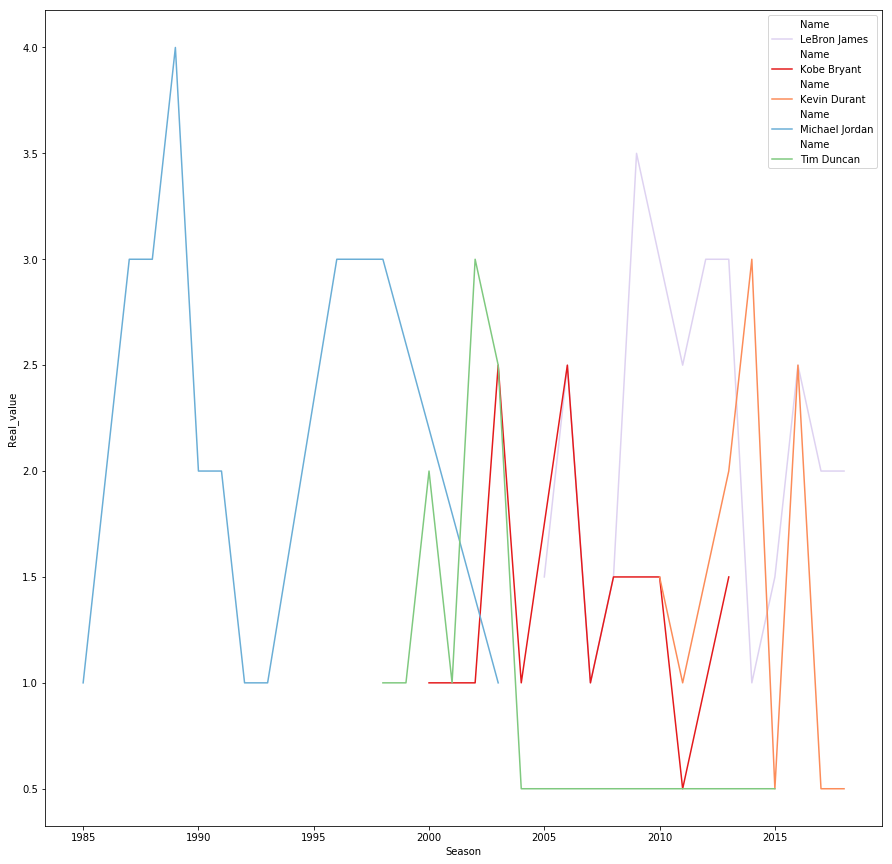

In [296]:
df_LBJ=nba[nba.Player=='LeBron James']
df_KB=nba[nba.Player=='Kobe Bryant']
df_KD=nba[nba.Player=='Kevin Durant']
df_MJ=nba[nba.Player=='Michael Jordan']
df_TD=nba[nba.Player=="Tim Duncan"]

LBJ=df_LBJ.groupby(['season_short']).sum()
LBJ['Season']=LBJ.index
LBJ['Name']='LeBron James'

KB=df_KB.groupby(['season_short']).sum()
KB['Season']=KB.index
KB['Name']='Kobe Bryant'

KD=df_KD.groupby(['season_short']).sum()
KD['Season']=KD.index
KD['Name']='Kevin Durant'

MJ=df_MJ.groupby(['season_short']).sum()
MJ['Season']=MJ.index
MJ['Name']='Michael Jordan'

TD=df_TD.groupby(['season_short']).sum()
TD['Season']=TD.index
TD['Name']="Tim Duncan"

plt.figure(figsize=(15,15))
sns.lineplot(x='Season',y='Real_value',data=LBJ,hue='Name', palette='ch:2.5,.25')
sns.lineplot(x='Season',y='Real_value',data=KB,hue='Name', palette='Set1')
sns.lineplot(x='Season',y='Real_value',data=KD,hue='Name', palette='OrRd')
sns.lineplot(x='Season',y='Real_value',data=MJ,hue='Name', palette='Blues')
sns.lineplot(x='Season',y='Real_value',data=TD,hue='Name', palette='Accent')

plt.show()

Here, we can see that Michael Jordan had the greatest impact, with a real value of 4.0 in 1990. However, LeBron had outstanding seasons from 2008-2010, rivalling Jordan with a real value of 3.5. This makes sense, as Michael Jordan and LeBron James are in fierce competition for the title of the greatest basketball player of all time. Tim Duncan was also amazing in 2003-2004, but he dropped of significantly afterwards. 